<a href="https://colab.research.google.com/github/bururaru/Food-101-with-VGGNET16/blob/master/lastest_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Check if GPU is enabled
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

1.13.1
/device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
cd/

/


In [0]:
cd content

/content


In [0]:
# Helper function to download data and extract
import os
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [0]:
# Download data and extract it to folder
get_data_extract()

In [0]:
# Check the extracted dataset folder
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [0]:
import os
os.listdir('food-101/images')

In [16]:
os.listdir('food-101/meta')

['train.json',
 'test.json',
 'test.txt',
 'classes.txt',
 'train.txt',
 'labels.txt']

In [0]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [0]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

In [0]:
# Helper method to split dataset into train and test folders
from shutil import copy
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [0]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

In [0]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

In [20]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [23]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [24]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
# from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
# for layer in vgg_conv.layers:
#   print(layer, layer.trainable)
  
model = models.Sequential()
 
model.add(vgg_conv)

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(101,kernel_regularizer=regularizers.l2(0.005), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              4097000   
_________________________________________________________________
dense_8 (Dense)              (None, 101)               101101    
Total params: 138,458,645
Trainable params: 130,823,381
Non-trainable params: 7,635,264
______________________________________________________

In [32]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
# from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

model = keras.models.load_model('best_model_101class_school.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              4097000   
_________________________________________________________________
dense_8 (Dense)              (None, 101)               101101    
Total params: 138,458,645
Trainable params: 130,823,381
Non-trainable params: 7,635,264
______________________________________________________

In [34]:
from google.colab import files
import os
import shutil


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 128
val_batchsize = 64
train_dir = 'food-101/train'
validation_dir = 'food-101/test'
n_classes = 101
image_size = 224
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.RMSprop(lr=1e-3),
#               metrics=['acc'])

# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
#               metrics=['acc'])

# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#               metrics=['acc'])

checkpointer = ModelCheckpoint(filepath='best_model_101class_school.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history2.log', separator='/', append=True)

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=16,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1,
      callbacks=[csv_logger, checkpointer])
 
# Save the model
model.save('best_model_101class_school.hdf5')

shutil.copy("/content/history2.log", "/gdrive/My Drive")
shutil.copy("/content/best_model_101class_school.hdf5", "/gdrive/My Drive")

# files.download('best_model_101class.hdf5')
# files.download('history.log')

# source_path = "/content/best_model_101class_school.hdf5"
# target_path = "/gdrive/My Drive"

# if not os.path.exists(target_path):
#     shutil.copy(source_path, target_path)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Epoch 1/16
395/395 [==============================] - 160s 404ms/step - loss: 3.5770 - acc: 0.3332

Epoch 00001: val_loss improved from inf to 3.57699, saving model to best_model_101class_school.hdf5
592/592 [==============================] - 1351s 2s/step - loss: 3.9825 - acc: 0.2608 - val_loss: 3.5770 - val_acc: 0.3332
Epoch 2/16
395/395 [==============================] - 159s 402ms/step - loss: 3.4122 - acc: 0.3682

Epoch 00002: val_loss improved from 3.57699 to 3.41224, saving model to best_model_101class_school.hdf5
592/592 [==============================] - 1325s 2s/step - loss: 3.8107 - acc: 0.2937 - val_loss: 3.4122 - val_acc: 0.3682
Epoch 3/16
395/395 [==============================] - 158s 400ms/step - loss: 3.2981 - acc: 0.3846

Epoch 00003: val_loss improved from 3.41224 to 3.29814, saving model to best_model_101class_school.hdf5
592/592 [==============================] - 1322s 2s/step

'/gdrive/My Drive/best_model_101class_school.hdf5'

In [36]:
shutil.copy("/content/history2.log", "/gdrive/My Drive")
shutil.copy("/content/best_model_101class_school.hdf5", "/gdrive/My Drive")

'/gdrive/My Drive/best_model_101class_school.hdf5'

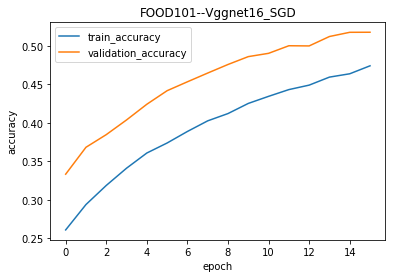

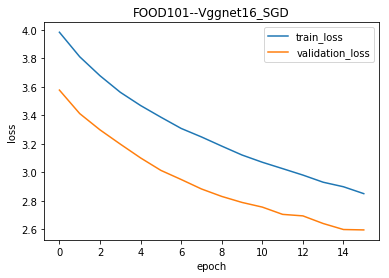

In [35]:
import matplotlib.pyplot as plt
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101--Vggnet16_SGD')
plot_loss(history,'FOOD101--Vggnet16_SGD')